#  A360 Anacal

Xiangchong Li \
LSST Science Piplines version: v29_0_0_rc5\
Container Size: large

This notebook is a condensed set of code to obtain make image mask and run AnaCal on LSST exposures

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Familiar stack packages
import healsparse
import numpy as np
from lsst.daf.butler import Butler
import lsst.geom as geom
from astropy.io import ascii as astascii

from astropy.visualization import ZScaleInterval
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.integrate as integrate
import anacal
import fitsio

In [4]:
# Load a recent version of DP1 for ComCam
obs_repo = '/repo/main'
#obs_collection = 'LSSTComCam/runs/DRP/DP1/w_2025_13/DM-49751'
#obs_collection = 'LSSTComCam/runs/DRP/DP1/w_2025_10/DM-49359'
obs_collection = 'LSSTComCam/runs/DRP/DP1/v29_0_0_rc5/DM-49865'
skymap = 'lsst_cells_v1'

obs_butler = Butler(obs_repo, collections=obs_collection)
obs_registry = obs_butler.registry
t_skymap = obs_butler.get('skyMap', skymap=skymap)

In [5]:
def get_image_mask_from_healsparse(exposure, hsmap):
    """
    Given an LSST exposure and a HealSparse mask file, return a 2D mask array.

    Parameters
    ----------
    exposure : lsst.afw.image.ExposureF
        The LSST exposure containing WCS info.
    hsmap : str
        HealSparse map

    Returns
    -------
    mask_2d : np.ndarray (bool)
        True means the pixel is masked (i.e., bad), False is good.
    """
    
    wcs = exposure.getWcs()
    height, width = exposure.getDimensions()
    y0 = exposure.getY0()
    x0 = exposure.getX0()
    # Generate grid of pixel coordinates
    y_pix, x_pix = np.indices((height, width))
    x_flat = x_pix.ravel() + x0 + 0.0
    y_flat = y_pix.ravel() + y0 + 0.0
    ra, dec = wcs.pixelToSkyArray(y=y_flat, x=x_flat, degrees=True)
    mask_flat = hsmap.get_values_pos(ra, dec)
    return mask_flat.reshape((height, width))

In [8]:
planes0 = ["BAD", "CR", "NO_DATA", "SAT", "UNMASKEDNAN"]
planes = [ "BAD", "CR", "NO_DATA", "SAT", "UNMASKEDNAN"]

badplanes = {
    "g": planes0,
    "r": planes,
    "i": planes,
    "z": planes,
}

hsmap = healsparse.HealSparseMap.read(
    "/sdf/home/a/amouroux/public_html/dp1_masks/masks_Rubin_SV_38_7.hs"
)

tract_id = 10463
patch_id = 62 
band = "i"

ref = list(obs_registry.queryDatasets(
    "deep_coadd", skymap=skymap, patch=patch_id,
    tract=tract_id, band=band,
))[0]
exposure = obs_butler.get(ref)
mask_array = get_image_mask_from_healsparse(exposure, hsmap)
bitv = exposure.mask.getPlaneBitMask(badplanes[band])
mask_array = mask_array | ((exposure.mask.array & bitv) != 0)
for band in ["g", "r", "z", "y"]:
    try:
        ref = list(obs_registry.queryDatasets(
            "deep_coadd", skymap=skymap, patch=patch_id,
            tract=tract_id, band=band,
        ))[0]
        exposure = obs_butler.get(ref)
        bitv = exposure.mask.getPlaneBitMask(badplanes[band])
        mask_array = mask_array | ((exposure.mask.array & bitv) != 0)
    except:
        print("cannot do for %s" % band)
mask_array = mask_array.astype(np.int16)
star_cat = np.array(
    astascii.read(f"/sdf/data/rubin/shared/cluster_commissioning/AnaCal/brightStars/{tract_id}-{patch_id}.ecsv")
)
anacal.mask.add_bright_star_mask(mask_array=mask_array, star_array=star_cat)

cannot do for y


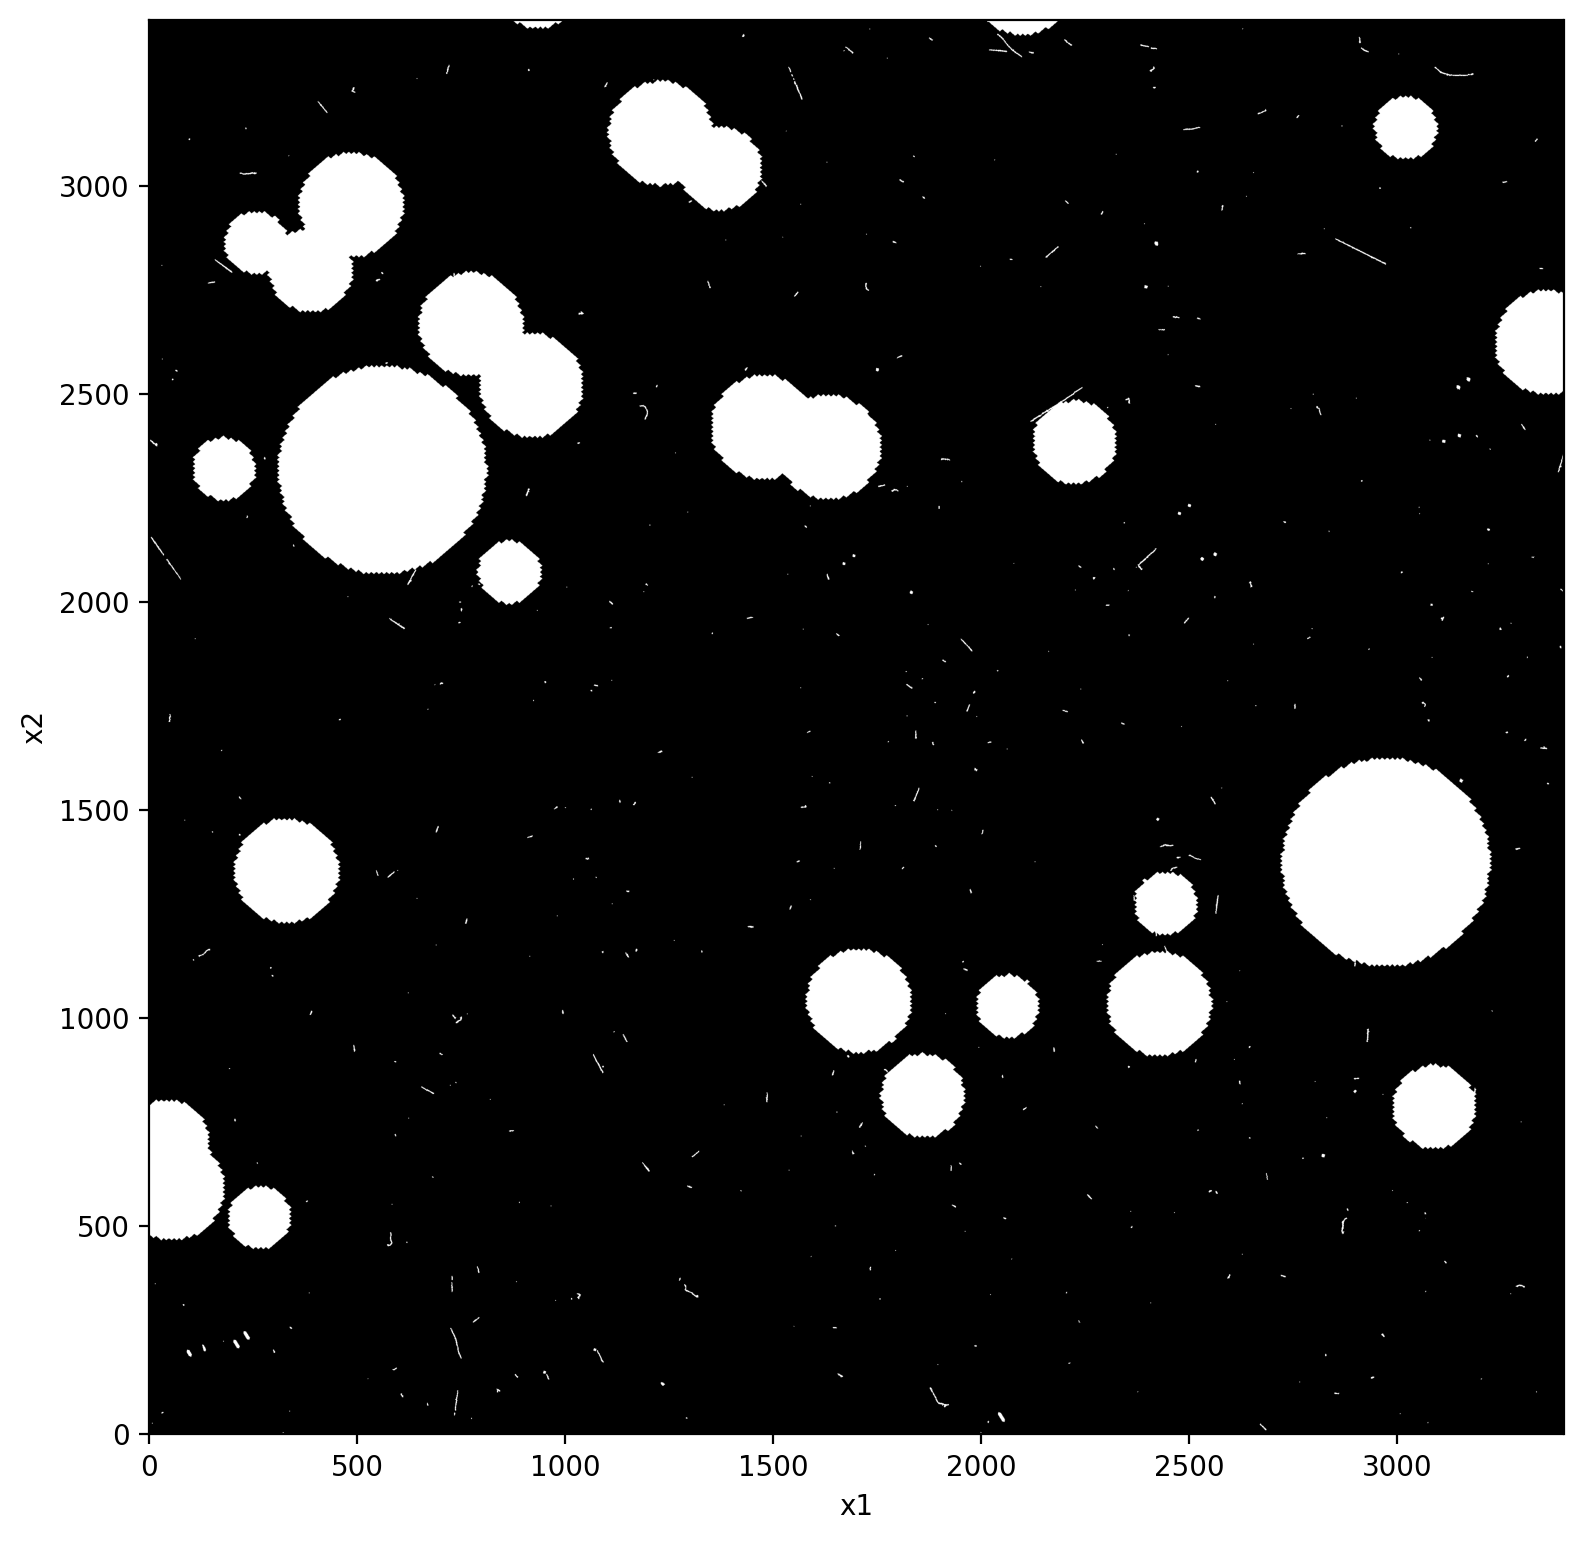

In [10]:
image = mask_array

# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, origin='lower', cmap='gray')

ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.show()

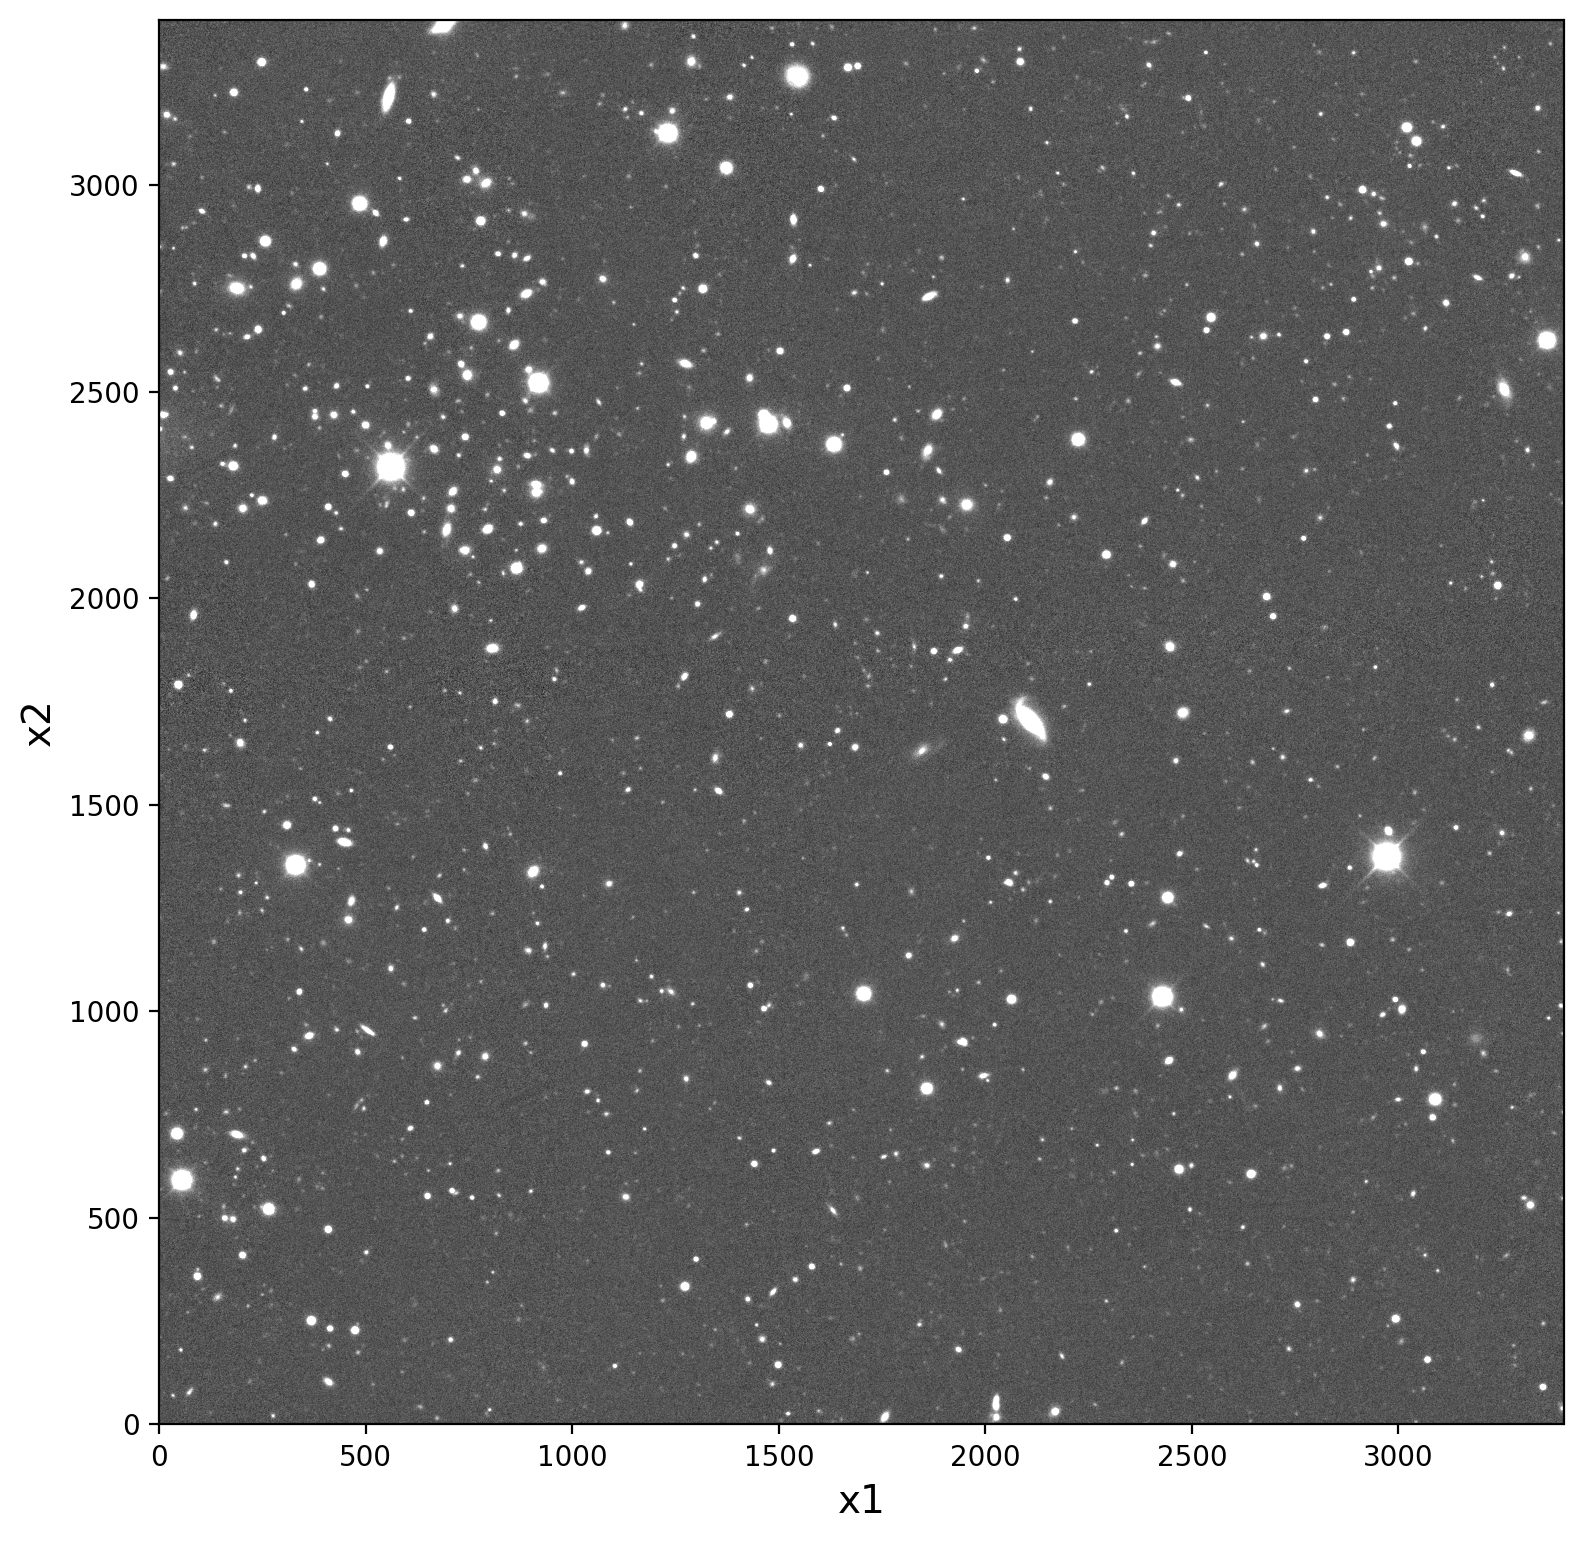

In [128]:
band = "z"
ref = list(obs_registry.queryDatasets(
    "deep_coadd", skymap=skymap, patch=patch_id,
    tract=tract_id, band=band,
))[0]
exposure = obs_butler.get(ref)
# Example inputs: replace with your actual data
image = exposure.image.array 
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
ax.set_xlabel("x1", fontsize=14)
ax.set_ylabel("x2", fontsize=14)

plt.tight_layout()
plt.show()

In [129]:
version = "v6"
ref = list(obs_registry.queryDatasets(
    "deep_coadd", skymap=skymap, patch=patch_id,
    tract=tract_id, band=band,
))[0]
exposure = obs_butler.get(ref)

mask_fname = f"/sdf/data/rubin/shared/cluster_commissioning/AnaCal/mask/{tract_id}-{patch_id}.fits"
mask_array = fitsio.read(mask_fname)

cat_fname = f"/sdf/data/rubin/shared/cluster_commissioning/AnaCal/catalog_{version}/detect_{tract_id}-{patch_id}.fits"
det = fitsio.read(cat_fname)

In [130]:
plt.hist(det["fpfs_e1"] )

(array([  9.,  31.,  80., 230., 287., 105.,  30.,   4.,   0.,   1.]),
 array([-0.38513473, -0.29250184, -0.19986895, -0.10723606, -0.01460317,
         0.07802972,  0.17066261,  0.2632955 ,  0.35592839,  0.44856128,
         0.54119417]),
 <BarContainer object of 10 artists>)

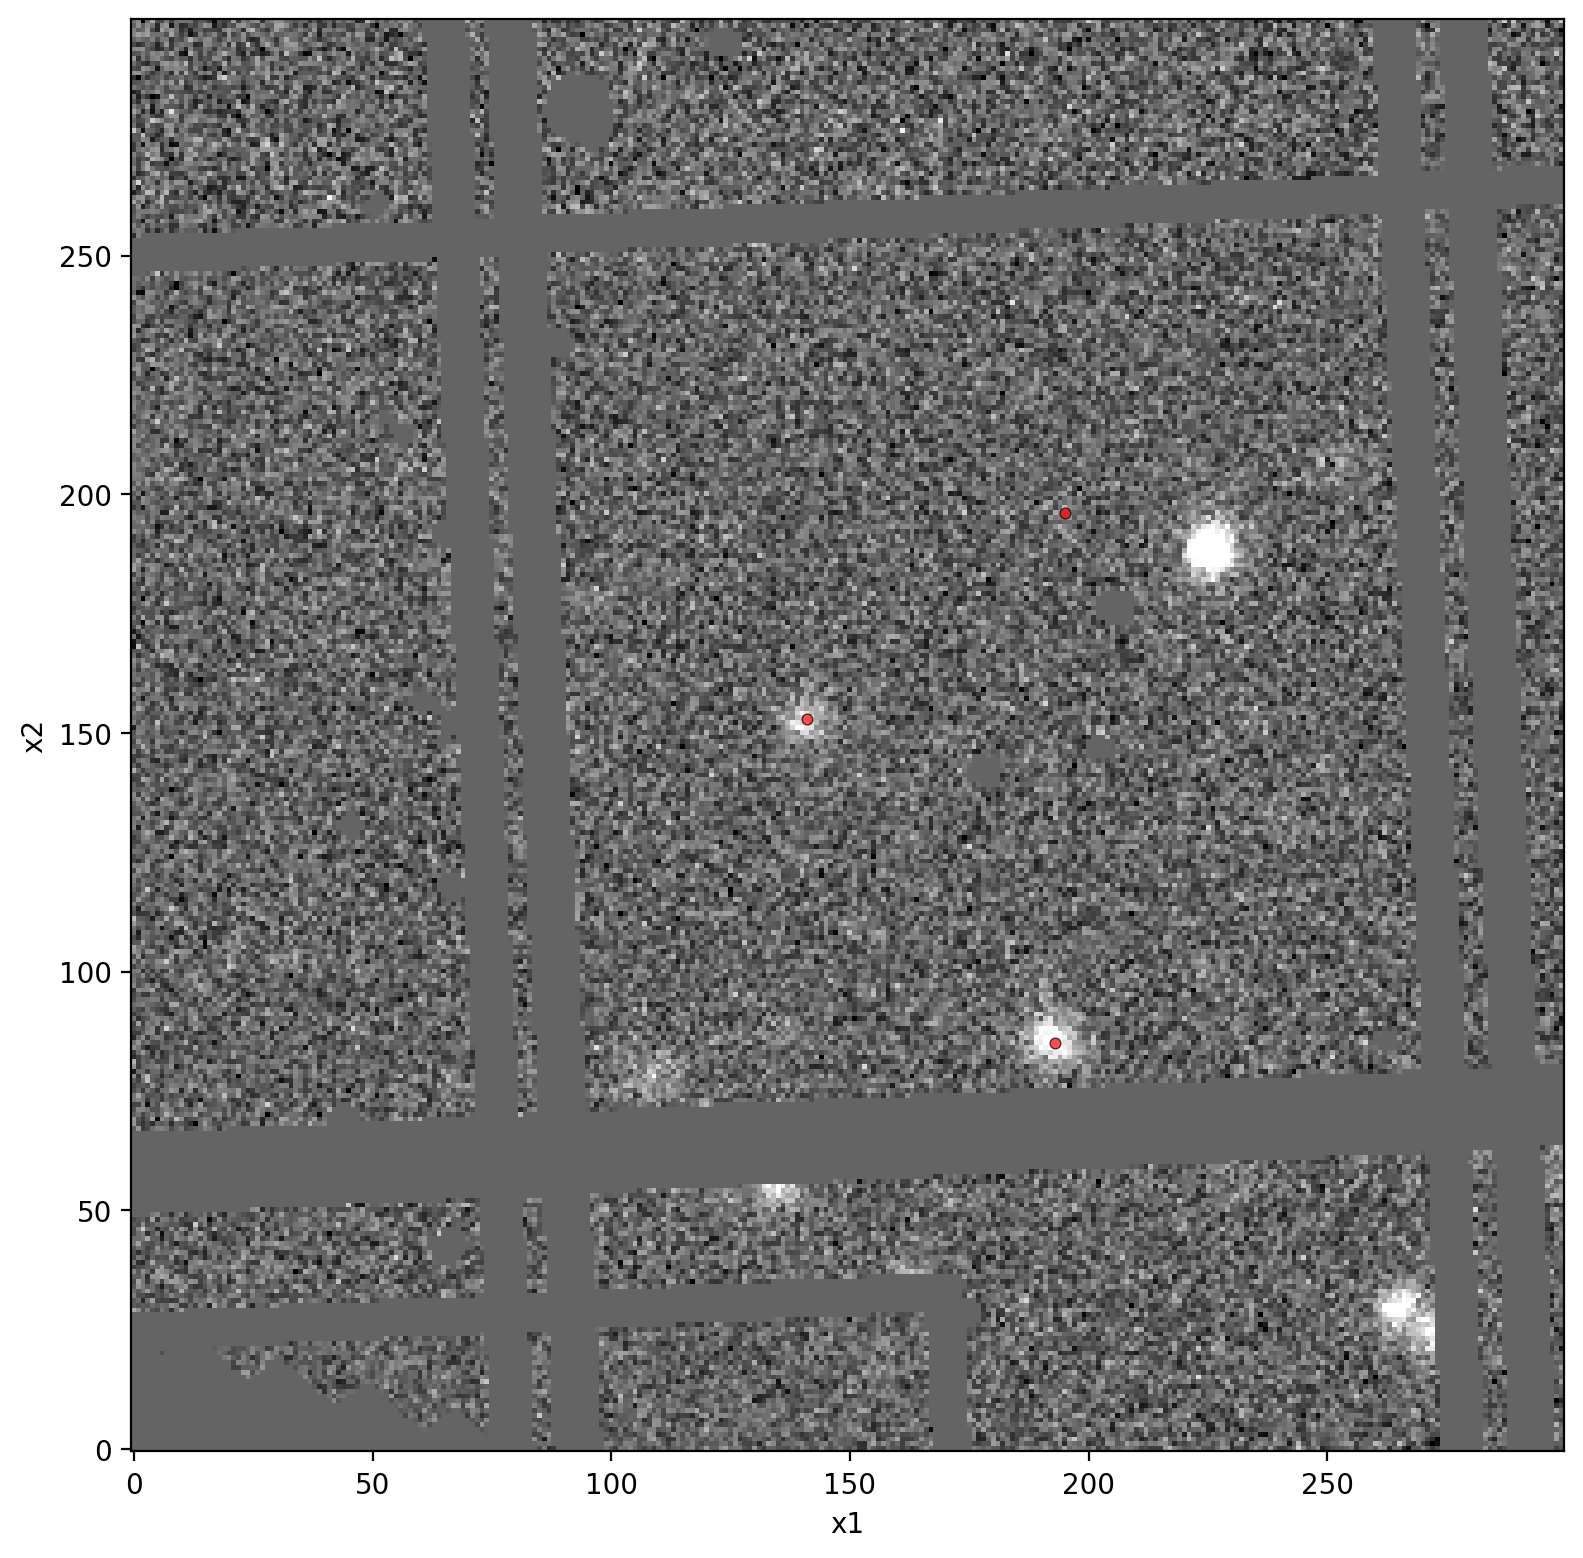

In [131]:
xstart = 3000
ystart = 1600
delt = 300
image = (exposure.image.array * -1.0 * (mask_array - 1.0))[ystart:ystart+delt, xstart:xstart+delt]
msk = det["fpfs_e2"] > 0.4
# Example inputs: replace with your actual data
x1 = det["x1"]/ 0.2 - exposure.getX0() - xstart
x2 = det["x2"] / 0.2 - exposure.getY0() - ystart
msk = (x1 >0) & (x2>0) & (x1<delt) & (x2<delt)
det = det[msk]
# Example inputs: replace with your actual data
x1 = det["x1"]/ 0.2 - exposure.getX0() - xstart
x2 = det["x2"] / 0.2 - exposure.getY0() - ystart


# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
ax.scatter(x1, x2, s=15, c='red', edgecolors='black', linewidths=0.5, alpha=0.7)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.show()

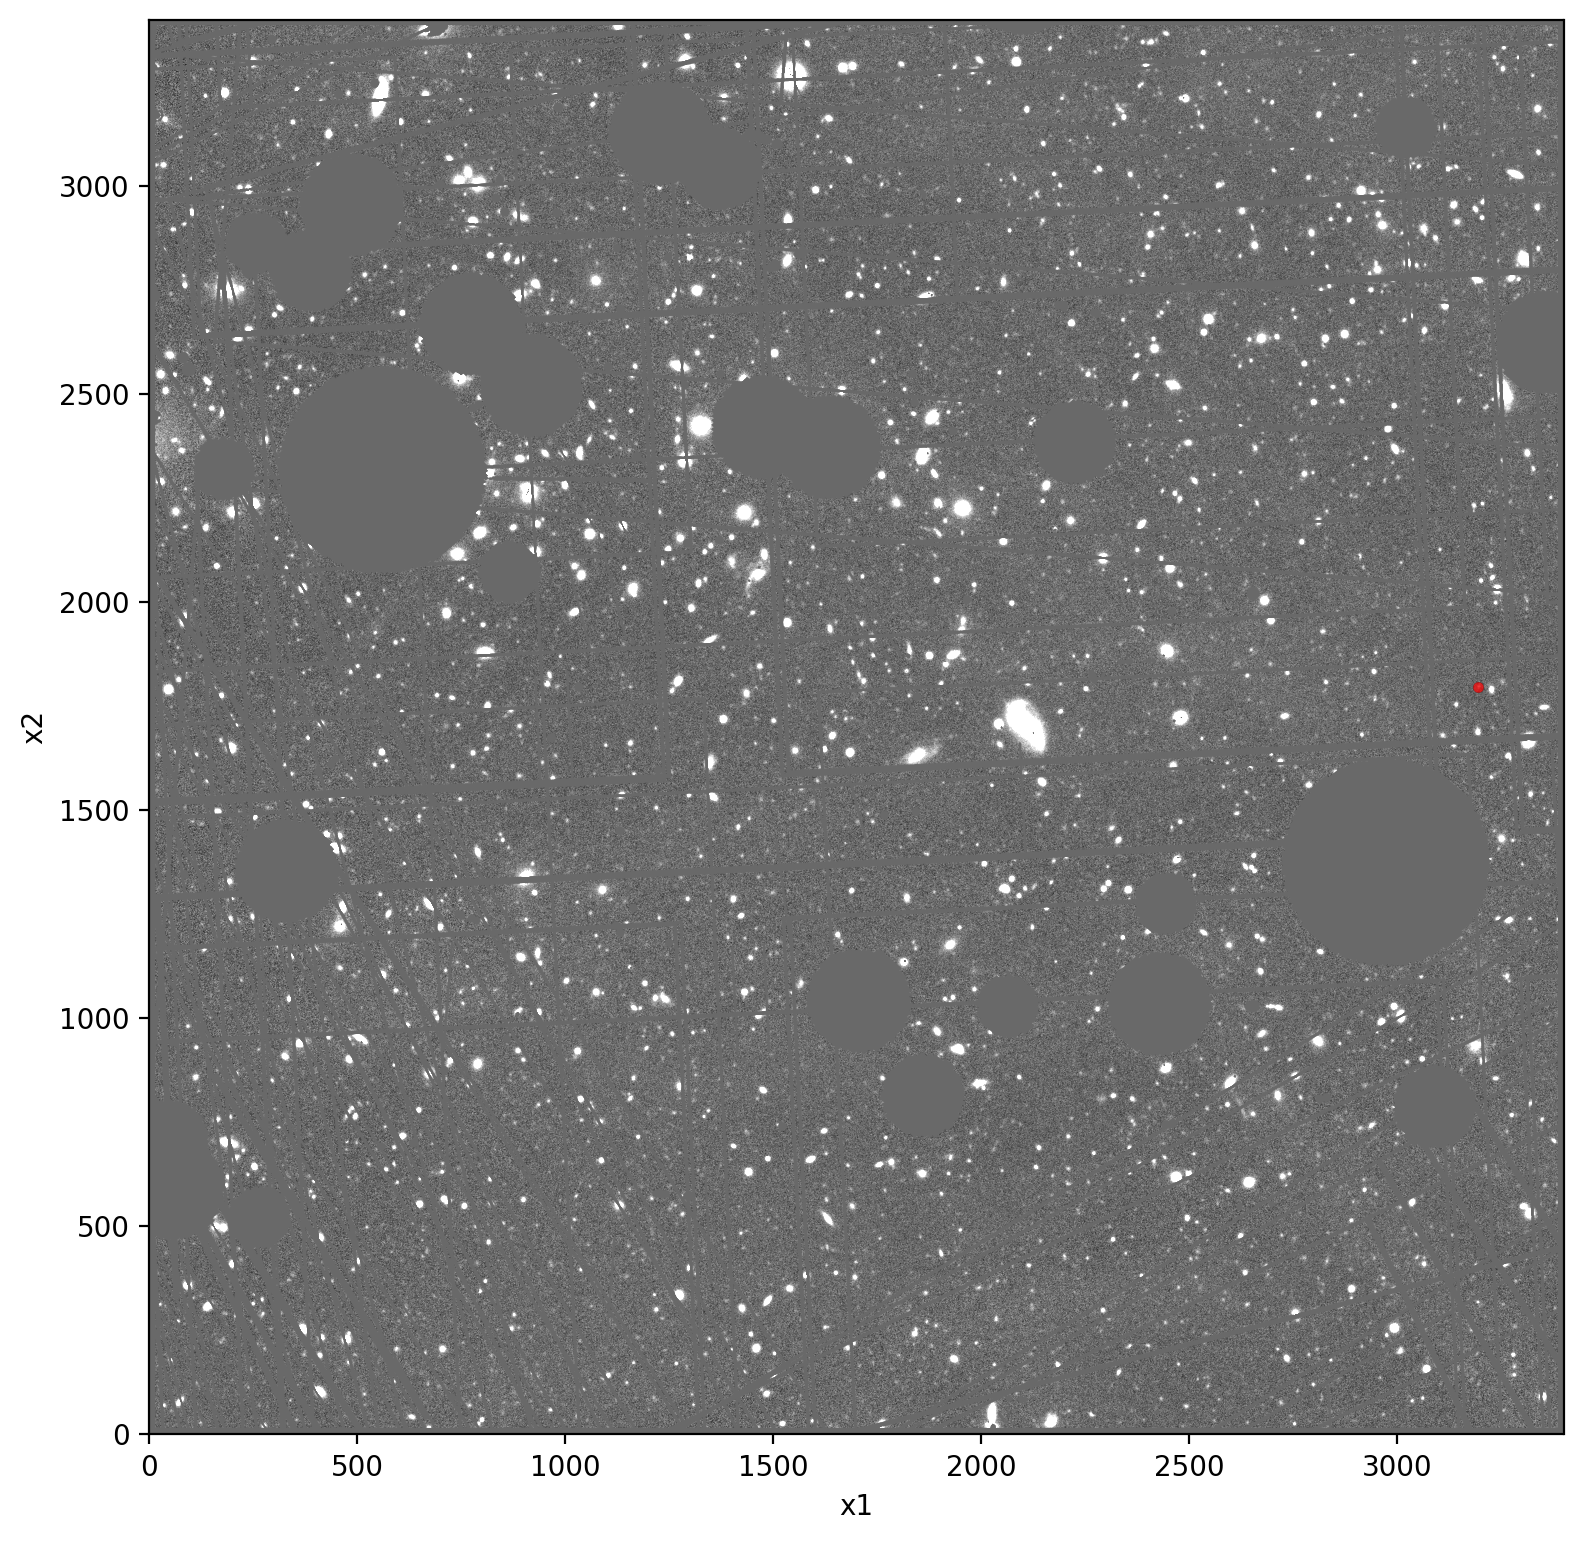

In [113]:
image = (exposure.image.array * -1.0 * (mask_array - 1.0))
msk = det["fpfs_e2"] > 0.3
det = det[msk]
# Example inputs: replace with your actual data
x1 = det["x1"]/ 0.2 - exposure.getX0() 
x2 = det["x2"] / 0.2 - exposure.getY0() 
# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
ax.scatter(x1, x2, s=15, c='red', edgecolors='black', linewidths=0.1, alpha=0.7)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.show()

In [80]:
det["x1"] / 0.2 - exposure.getX0() 

array([2125.99999892])

In [82]:
det["wsel"]

array([1.], dtype='>f8')

In [85]:
det["flux"]

array([3251.0792089], dtype='>f8')

In [124]:
det["e2"]

array([-0.3026566 ,  0.2434403 ,  0.99932689], dtype='>f8')

In [125]:
det["fpfs_e2"]

array([-0.07109359,  0.04683016,  0.31713559], dtype='>f8')

In [127]:
det["e1"]

array([-0.08525331, -0.38403457, -0.03657674], dtype='>f8')

In [ ]:
plt.hist

In [84]:
det["peakv"] / det["fluxap2"]

array([0.0069968])

In [29]:
wcs = exposure.getWcs()

In [24]:
wcs.skyToPixelArray([ 37.865017], [6.982205], degrees=True)

(array([5696.99283106]), array([20188.00332735]))

In [26]:
exposure.getX0()

5800

In [27]:
exposure.getY0()

17800